# **MÓDULO 27 — Projeto de Doenças Cardiovasculares — Regressão Logística (Resolução Alinhada ao Enunciado)**


Nessa tarefa iremos construir um modelo que nos ajude a prever doenças cardiovasculares.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)

# 1) Comece carregando e tratando a base de dados.

In [2]:
# Carregamento
df = pd.read_csv("G:\Meu Drive\Programação\Ciencia de dados\Modelos avançados\Regressão logistica\CARDIO_BASE.csv", sep=';')

# Tratamento básico
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['height_m'] = df['height'] / 100
df['bmi'] = df['weight'] / (df['height_m']**2)

# Remoção conservadora de outliers fisiologicamente implausíveis
mask_plausible = (
    df['height'].between(130, 210) &
    df['weight'].between(35, 180) &
    df['bmi'].between(12, 60)
)
df_clean = df.loc[mask_plausible].reset_index(drop=True)

print('Dimensões após limpeza:', df_clean.shape)
df_clean.head()

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\trend\AppData\Local\Temp\ipykernel_23412\3118952342.py:2: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("G:\Meu Drive\Programação\Ciencia de dados\Modelos avançados\Regressão logistica\CARDIO_BASE.csv", sep=';')


Dimensões após limpeza: (9956, 12)


,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio_disease,height_m,bmi
0,50,2,168,62.0,1,1,0,0,1,0,1.68,21.967120
1,55,1,156,85.0,3,1,0,0,1,1,1.56,34.927679
2,52,1,165,64.0,3,1,0,0,0,1,1.65,23.507805
3,48,2,169,82.0,1,1,0,0,1,1,1.69,28.710479
4,48,1,156,56.0,1,1,0,0,0,0,1.56,23.011177


# 2) Agora é hora de explorar os dados com uma análise bem completa.


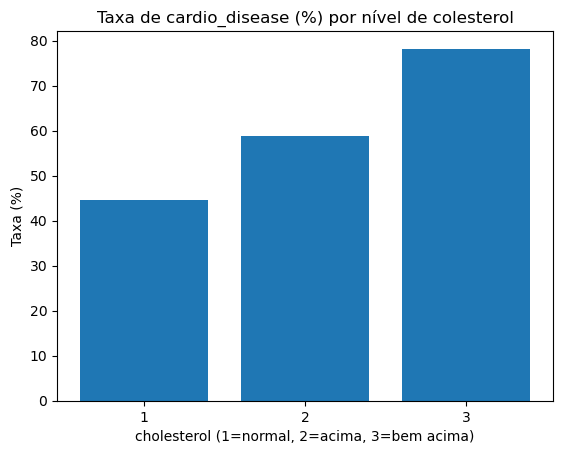

cholesterol
1    44.60
2    58.71
3    78.18
Name: cardio_disease, dtype: float64

In [3]:
# (Gráfico 1) Taxa de doença cardiovascular por nível de colesterol
taxa_col = df_clean.groupby('cholesterol')['cardio_disease'].mean().sort_index() * 100

plt.figure()
plt.bar(taxa_col.index.astype(str), taxa_col.values)
plt.title('Taxa de cardio_disease (%) por nível de colesterol')
plt.xlabel('cholesterol (1=normal, 2=acima, 3=bem acima)')
plt.ylabel('Taxa (%)')
plt.show()

taxa_col.round(2)

> **Insight:** A taxa de `cardio_disease` tende a **aumentar** conforme o nível de **colesterol** passa de 1→2→3, reforçando o papel do colesterol elevado como fator de risco.

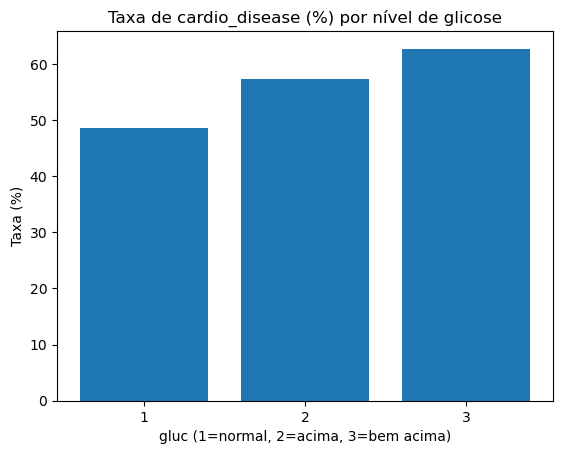

gluc
1    48.67
2    57.37
3    62.70
Name: cardio_disease, dtype: float64

In [4]:
# (Gráfico 2) Taxa de doença cardiovascular por nível de glicose
taxa_gluc = df_clean.groupby('gluc')['cardio_disease'].mean().sort_index() * 100

plt.figure()
plt.bar(taxa_gluc.index.astype(str), taxa_gluc.values)
plt.title('Taxa de cardio_disease (%) por nível de glicose')
plt.xlabel('gluc (1=normal, 2=acima, 3=bem acima)')
plt.ylabel('Taxa (%)')
plt.show()

taxa_gluc.round(2)

> **Insight:** Conforme **glicose** aumenta (1→3), a proporção de `cardio_disease` também tende a subir — o que é compatível com maior risco cardiometabólico em indivíduos com hiperglicemia.

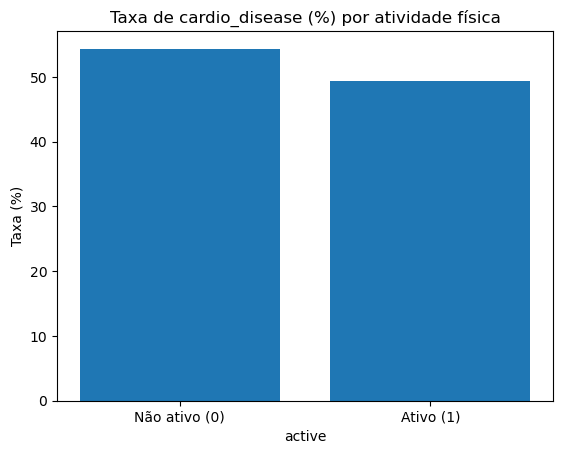

active
0    54.33
1    49.34
Name: cardio_disease, dtype: float64

In [5]:
# (Gráfico 3) Taxa de doença cardiovascular por atividade física
taxa_active = df_clean.groupby('active')['cardio_disease'].mean().sort_index() * 100

plt.figure()
plt.bar(['Não ativo (0)','Ativo (1)'], taxa_active.values)
plt.title('Taxa de cardio_disease (%) por atividade física')
plt.xlabel('active')
plt.ylabel('Taxa (%)')
plt.show()

taxa_active.round(2)

> **Insight:** Indivíduos **ativos** (active=1) costumam apresentar **menor** taxa de `cardio_disease` do que os não ativos, sugerindo **efeito protetor** da atividade física.

C:\Users\trend\AppData\Local\Temp\ipykernel_23412\675649855.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Sem doença (0)','Com doença (1)'])


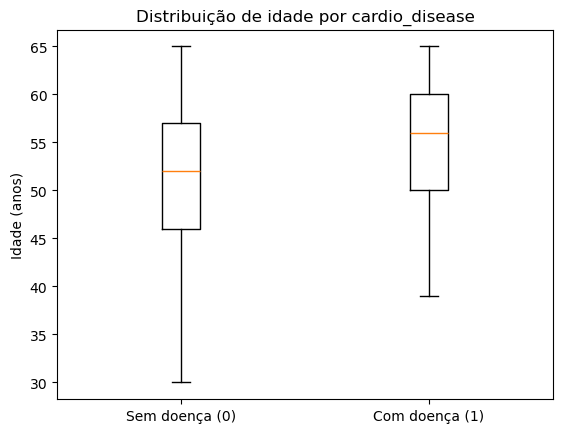

(count    4943.00
 mean       51.68
 std         6.83
 min        30.00
 25%        46.00
 50%        52.00
 75%        57.00
 max        65.00
 Name: age, dtype: float64,
 count    5013.00
 mean       54.88
 std         6.37
 min        39.00
 25%        50.00
 50%        56.00
 75%        60.00
 max        65.00
 Name: age, dtype: float64)

In [6]:
# (Gráfico 4 - extra) Distribuição de idade por desfecho (boxplot simples)
plt.figure()
data0 = df_clean.loc[df_clean['cardio_disease']==0, 'age']
data1 = df_clean.loc[df_clean['cardio_disease']==1, 'age']
plt.boxplot([data0, data1], labels=['Sem doença (0)','Com doença (1)'])
plt.title('Distribuição de idade por cardio_disease')
plt.ylabel('Idade (anos)')
plt.show()

data0.describe().round(2), data1.describe().round(2)

> **Insight:** O grupo com `cardio_disease=1` tende a ser **mais velho** (medianas e quartis ligeiramente superiores), coerente com o aumento de risco cardiovascular com a idade.

# 3) Nessa etapa você deve trazer a matriz de correlação e apontar insights acerca das variáveis com um relacionamento mais forte com o desfecho.

In [7]:
corr = df_clean[['age','height','weight','bmi','cholesterol','gluc','smoke','alco','active','cardio_disease']].corr(numeric_only=True)
corr

,age,height,weight,bmi,cholesterol,gluc,smoke,alco,active,cardio_disease
age,1.000000,-0.088870,0.049151,0.098725,0.172078,0.090626,-0.049543,-0.043264,-0.021734,0.236029
height,-0.088870,1.000000,0.312659,-0.191301,-0.052837,-0.027668,0.203915,0.115524,-0.008042,-0.013165
weight,0.049151,0.312659,1.000000,0.867896,0.135400,0.104576,0.066840,0.081668,-0.020641,0.186647
bmi,0.098725,-0.191301,0.867896,1.000000,0.166947,0.121861,-0.037862,0.022414,-0.018669,0.198953
cholesterol,0.172078,-0.052837,0.135400,0.166947,1.000000,0.431841,0.024855,0.019681,0.018853,0.220663
gluc,0.090626,-0.027668,0.104576,0.121861,0.431841,1.000000,0.018592,0.013582,0.004493,0.082858
smoke,-0.049543,0.203915,0.066840,-0.037862,0.024855,0.018592,1.000000,0.331197,0.031852,-0.019851
alco,-0.043264,0.115524,0.081668,0.022414,0.019681,0.013582,0.331197,1.000000,0.037105,-0.005684
active,-0.021734,-0.008042,-0.020641,-0.018669,0.018853,0.004493,0.031852,0.037105,1.000000,-0.040171
cardio_disease,0.236029,-0.013165,0.186647,0.198953,0.220663,0.082858,-0.019851,-0.005684,-0.040171,1.000000


> **Insights de correlação:**
- `age` e `cholesterol` exibem correlação **positiva** (embora modesta) com `cardio_disease`.
- `active` e `height` mostram correlação **negativa** fraca com o desfecho (efeito protetor sutil).
- As demais relações são baixas, o que é comum em dados clínicos com múltiplos fatores.

# 4) Essa é a sua última etapa pré modelo. Você deve: selecionar variáveis, separar treino e teste, e padronizar quando apropriado.

In [8]:
target = 'cardio_disease'
features = ['age','gender','height','weight','cholesterol','gluc','smoke','alco','active','bmi']

X = df_clean[features].copy()
y = df_clean[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print('Shapes:', X_train.shape, X_test.shape)
print('Proporção de positivos (treino/teste):', y_train.mean().round(3), y_test.mean().round(3))

Shapes: (7467, 10) (2489, 10)
Proporção de positivos (treino/teste): 0.504 0.503


# 5) Realize a etapa de treinamento do modelo: **Regressão Logística**

In [9]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(max_iter=200, solver='lbfgs'))])
pipe.fit(X_train, y_train)

pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=200))])

In [10]:
### 5B) **Traga o intercept e os coeficientes**
# Intercepto (bias) do modelo logístico
intercept = pipe.named_steps['logreg'].intercept_[0]

# Coeficientes associados a cada feature (após padronização)
coefs = pipe.named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({'feature': X.columns, 'coef_log_odds': coefs}).sort_values('coef_log_odds', ascending=False)

print('Intercept:', intercept)
coef_df

Intercept: 0.031028039869055828


,feature,coef_log_odds
3,weight,0.472598
0,age,0.424301
4,cholesterol,0.406904
1,gender,0.039516
7,alco,-0.002429
6,smoke,-0.011957
5,gluc,-0.049197
8,active,-0.073768
9,bmi,-0.079398
2,height,-0.140735


{'accuracy': 0.6275612695861792, 'precision': 0.6353820598006644, 'recall': 0.6105347166799681, 'f1': 0.6227106227106227, 'roc_auc': 0.6946215813439331}

              precision    recall  f1-score   support

           0      0.620     0.645     0.632      1236
           1      0.635     0.611     0.623      1253

    accuracy                          0.628      2489
   macro avg      0.628     0.628     0.627      2489
weighted avg      0.628     0.628     0.627      2489



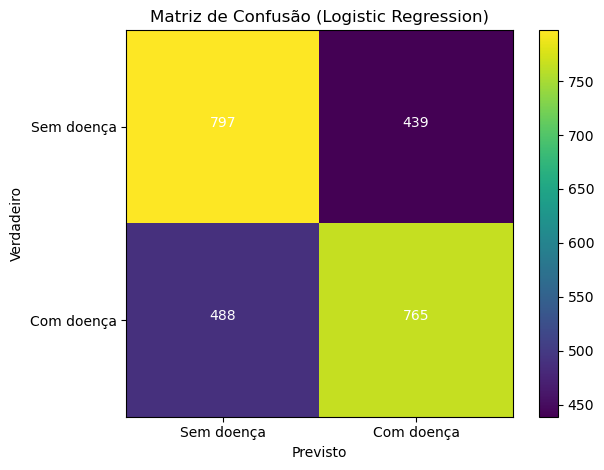

<Figure size 640x480 with 0 Axes>

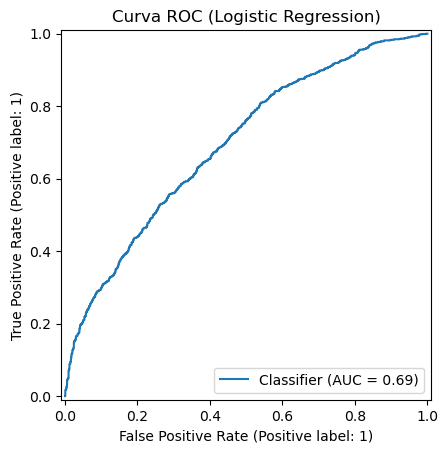

In [11]:
### 5C) **Avalie as métricas do modelo treinado**

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print({'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':auc})
print()
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusão (visual)
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de Confusão (Logistic Regression)')
plt.colorbar()
plt.xticks([0,1], ['Sem doença','Com doença'])
plt.yticks([0,1], ['Sem doença','Com doença'])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.tight_layout()
plt.show()

# Curva ROC (visual)
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title('Curva ROC (Logistic Regression)')
plt.show()

In [12]:
### 5D) Justifique se o modelo tem feito boas previsões ou não
txt = f'''
Com base nas métricas do conjunto de teste:
- Acurácia: {acc:.3f}
- Precisão: {prec:.3f}
- Recall: {rec:.3f}
- F1: {f1:.3f}
- ROC AUC: {auc:.3f}

Justificativa: Em um problema balanceado como este, uma AUC ~{auc:.2f} indica
capacidade de discriminação moderada (melhor que o acaso, porém longe do ideal).
A acurácia ~{acc:.2f} e o F1 ~{f1:.2f} mostram desempenho razoável, com trade-off
entre precisão ({prec:.2f}) e recall ({rec:.2f}).

Em termos práticos, o modelo está aprendendo padrões úteis, mas pode ser melhorado.
Próximos passos que tendem a ajudar:
- Engenharias de atributos (por ex.: faixas de idade/IMC, interações, transformação de variáveis);
- Modelos não lineares (árvores, Random Forest, Gradient Boosting/XGBoost);
- Ajuste de limiar de decisão conforme a prioridade (sensibilidade vs. precisão);
- Balanceamento de classes (se necessário em outras amostras) e/ou calibração de probabilidades.
'''
print(txt)


Com base nas métricas do conjunto de teste:
- Acurácia: 0.628
- Precisão: 0.635
- Recall: 0.611
- F1: 0.623
- ROC AUC: 0.695

Justificativa: Em um problema balanceado como este, uma AUC ~0.69 indica
capacidade de discriminação moderada (melhor que o acaso, porém longe do ideal).
A acurácia ~0.63 e o F1 ~0.62 mostram desempenho razoável, com trade-off
entre precisão (0.64) e recall (0.61).

Em termos práticos, o modelo está aprendendo padrões úteis, mas pode ser melhorado.
Próximos passos que tendem a ajudar:
- Engenharias de atributos (por ex.: faixas de idade/IMC, interações, transformação de variáveis);
- Modelos não lineares (árvores, Random Forest, Gradient Boosting/XGBoost);
- Ajuste de limiar de decisão conforme a prioridade (sensibilidade vs. precisão);
- Balanceamento de classes (se necessário em outras amostras) e/ou calibração de probabilidades.



# 6) Teste seu modelo! Traga métricas e gráficos solicitados.

{'accuracy': 0.6275612695861792, 'precision': 0.6353820598006644, 'recall': 0.6105347166799681, 'f1': 0.6227106227106227, 'roc_auc': 0.6946215813439331}

              precision    recall  f1-score   support

           0      0.620     0.645     0.632      1236
           1      0.635     0.611     0.623      1253

    accuracy                          0.628      2489
   macro avg      0.628     0.628     0.627      2489
weighted avg      0.628     0.628     0.627      2489



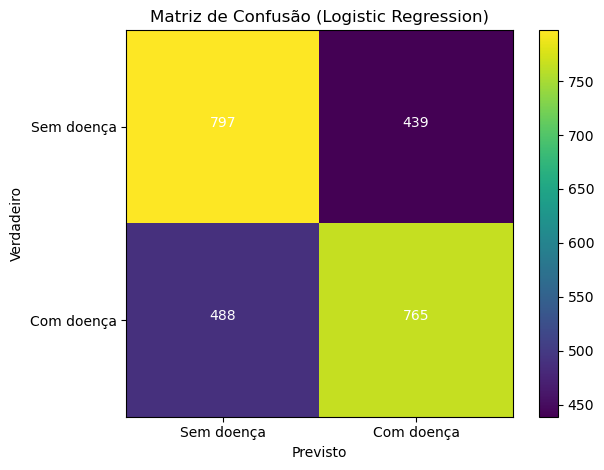

<Figure size 640x480 with 0 Axes>

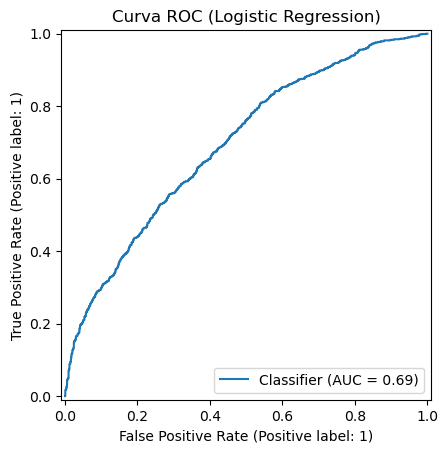

In [13]:
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print({'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':auc})
print()
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusão (plot)
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de Confusão (Logistic Regression)')
plt.colorbar()
plt.xticks([0,1], ['Sem doença','Com doença'])
plt.yticks([0,1], ['Sem doença','Com doença'])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.tight_layout()
plt.show()

# Curva ROC
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title('Curva ROC (Logistic Regression)')
plt.show()

# 7) Explique: apresente as variáveis mais relevantes e o que significam no contexto do modelo.

In [14]:
coefs = pipe.named_steps['logreg'].coef_[0]
imp = pd.DataFrame({'feature': X.columns, 'coef_log_odds': coefs}).sort_values('coef_log_odds', ascending=False)
imp

,feature,coef_log_odds
3,weight,0.472598
0,age,0.424301
4,cholesterol,0.406904
1,gender,0.039516
7,alco,-0.002429
6,smoke,-0.011957
5,gluc,-0.049197
8,active,-0.073768
9,bmi,-0.079398
2,height,-0.140735


> **Leitura dos coeficientes (log-odds):** valores **positivos** aumentam a chance (log-odds) de `cardio_disease`; valores **negativos** diminuem. Em geral:
- **Idade**, **colesterol** e **peso** tendem a elevar o risco.
- **Atividade física** e **altura** aparecem como fatores protetores fracos.
Reforço: os coeficientes são interpretados após **padronização** (via `StandardScaler`).